In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

In [8]:
def extract_box_data(file):

    box_bounds = {}
    with open(file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: BOX BOUNDS" in line:
                x_bounds = list(map(float, lines[i+1].split()))
                y_bounds = list(map(float, lines[i+2].split()))
                z_bounds = list(map(float, lines[i+3].split()))
                box_bounds = {
                    'xlo': x_bounds[0], 'xhi': x_bounds[1],
                    'ylo': y_bounds[0], 'yhi': y_bounds[1],
                    'zlo': z_bounds[0], 'zhi': z_bounds[1],
                }
                break
    return box_bounds

def extract_atom_data(file):

    with open(file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: ATOMS" in line:
                # Extract column headers from the line, ignoring the first two words
                headers = line.strip().split()[2:]
                data_start = i + 1
                break
    # Read atom data lines
    data_lines = lines[data_start:]
    # Convert each line to a list of floats
    data = [list(map(float, l.strip().split())) for l in data_lines]
    # Create DataFrame
    df = pd.DataFrame(data, columns=headers)
    return df

input_file = os.path.join(ROOT_DIR, 'src', '02_minimize_dislo', 'output', 'dump')

box = extract_box_data(input_file)
atom_df = extract_atom_data(input_file)

print("Box Dimensions:", box)
print("\nFirst few atoms:\n", atom_df.head())
print(f"\nNumber of atoms: {len(atom_df)}")

Box Dimensions: {'xlo': 0.0, 'xhi': 301.6748617821951, 'ylo': 0.0, 'yhi': 302.84814737336876, 'zlo': 0.0, 'zhi': 349.69891881918784}

First few atoms:
         id        x        y         z  c_peratom
0  39125.0  129.570  2.75664 -0.119156   -3.08003
1  39126.0  130.342  2.77332  2.304920   -3.29453
2  39569.0  132.044  2.72861  0.009668   -3.43616
3  39570.0  132.861  2.72555  2.338030   -3.43994
4  40013.0  134.533  2.72832  0.003727   -3.43860

Number of atoms: 2122500


In [9]:
def plot_atomistic_data_3d(atom_df, box, cmap='jet', alpha=0.8, s=2):
   
    required_cols = ['x', 'y', 'z', 'c_peratom']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    required_keys = ['xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi']
    if not all(k in box for k in required_keys):
        raise ValueError(f"Box must contain keys: {required_keys}")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    p = ax.scatter(atom_df['x'], atom_df['y'], atom_df['z'], 
                   c=atom_df['c_peratom'], cmap=cmap, alpha=alpha, s=s)

    ax.set_xlim(box['xlo'], box['xhi'])
    ax.set_ylim(box['ylo'], box['yhi'])
    ax.set_zlim(box['zlo'], box['zhi'])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Potential Energy per atom (eV)')

    plt.title('3D Atomistic Data')
    plt.tight_layout()
    plt.show()

    ## plot_atomistic_data_3d(atom_df, box)

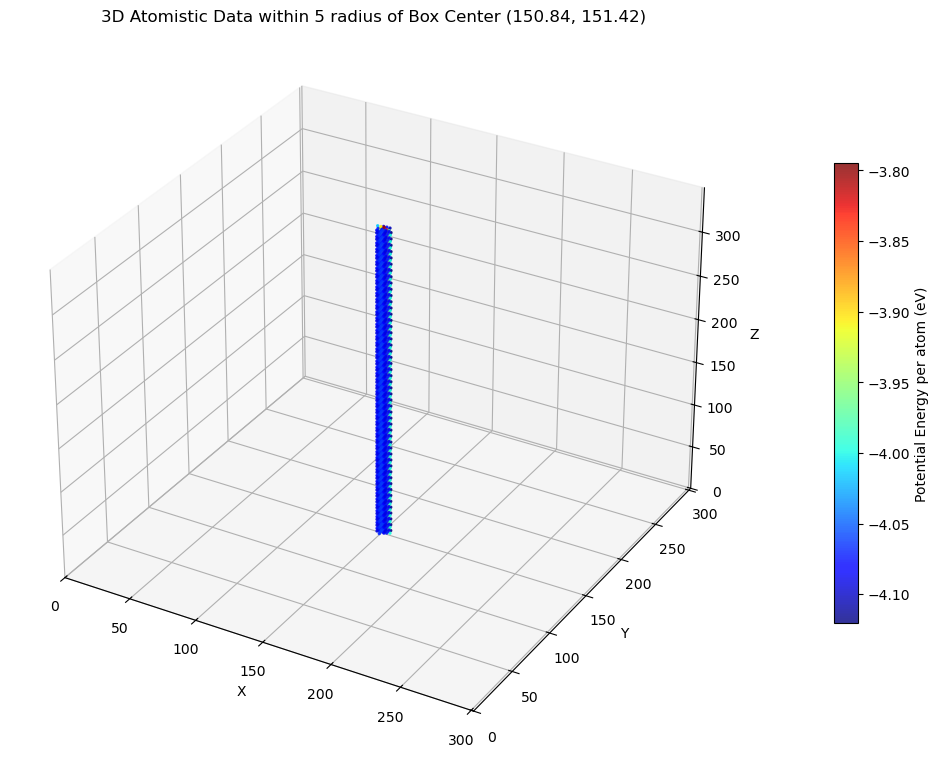

In [ ]:
def plot_dislo_core_3d(atom_df, box, radius, cmap='jet', alpha=0.8, s=2):

    required_cols = ['x', 'y', 'z', 'c_peratom']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    required_keys = ['xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi']
    if not all(k in box for k in required_keys):
        raise ValueError(f"Box must contain keys: {required_keys}")

    # Calculate the center of the simulation box
    center_x = (box['xlo'] + box['xhi']) / 2
    center_y = (box['ylo'] + box['yhi']) / 2

    # Calculate the distance of each atom from the box center
    distances = np.sqrt(
        (atom_df['x'] - center_x)**2 +
        (atom_df['y'] - center_y)**2
    )
    
    # Filter atoms within the specified radius
    filtered_atom_df = atom_df[distances <= radius].copy()

    if filtered_atom_df.empty:
        print(f"No atoms found within the specified radius ({radius}) from the box center ({center_x:.2f}, {center_y:.2f}, {center_z:.2f}).")
        return

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    p = ax.scatter(filtered_atom_df['x'], filtered_atom_df['y'], filtered_atom_df['z'], 
                   c=filtered_atom_df['c_peratom'], cmap=cmap, alpha=alpha, s=s)

    ax.set_xlim(box['xlo'], box['xhi'])
    ax.set_ylim(box['ylo'], box['yhi'])
    ax.set_zlim(box['zlo'], box['zhi'])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Potential Energy per atom (eV)')

    plt.title(f'3D Atomistic Data within {radius} radius of Box Center ({center_x:.2f}, {center_y:.2f})')
    plt.tight_layout()
    plt.show()

plot_dislo_core_3d(atom_df, box, 5)


Number of atoms in the dislocation core: 150



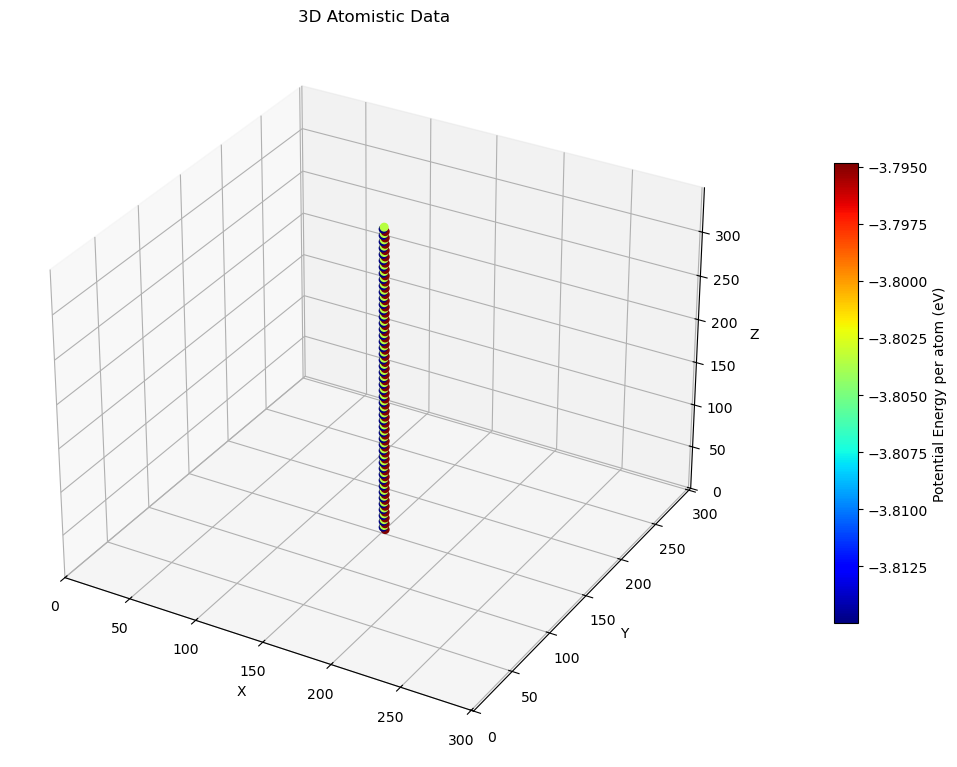

In [11]:
def filter_atoms(atom_df, box, radius, c_peratom_thresh=-4.0):
    
    # Calculate center coordinates of the simulation box in XY plane
    x_center = (box['xlo'] + box['xhi']) / 2
    y_center = (box['ylo'] + box['yhi']) / 2

    # Compute XY-plane distance of each atom from the box center
    dx = atom_df['x'] - x_center
    dy = atom_df['y'] - y_center
    r_xy = np.sqrt(dx**2 + dy**2)

    # Filter atoms based on energy and radius conditions
    filtered_df = atom_df[(atom_df['c_peratom'] > c_peratom_thresh) & (r_xy < radius)]

    return filtered_df

dislocation_df = filter_atoms(atom_df, box, radius=40, c_peratom_thresh=-3.82)
print(f"\nNumber of atoms in the dislocation core: {len(dislocation_df)}\n")

plot_atomistic_data_3d(dislocation_df, box, s=30, alpha=1)


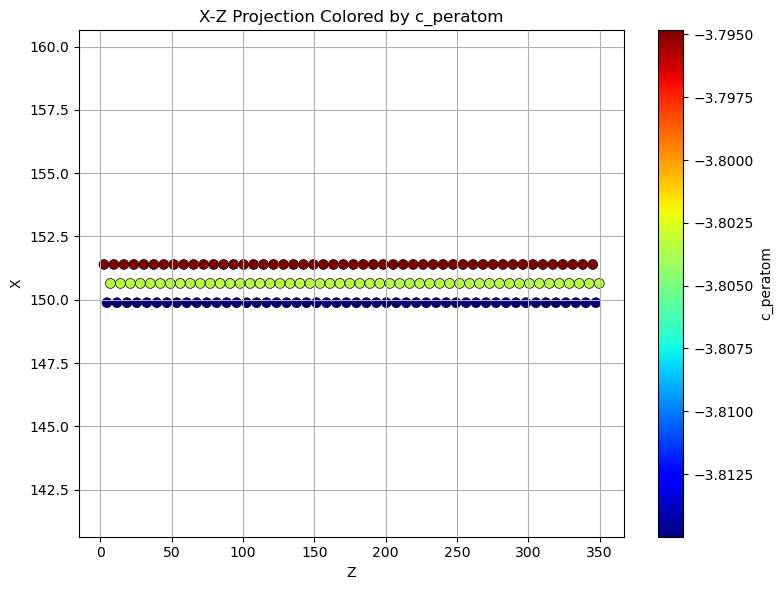

In [12]:
def plot_xz_colored_by_peratom(atom_df, cmap='jet', s=50, alpha=1, buffer=10):
    
    required_cols = ['x', 'z', 'c_peratom']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"atom_df must contain the following columns: {required_cols}")

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        atom_df['z'], atom_df['x'],
        c=atom_df['c_peratom'],
        cmap=cmap,
        s=s,
        alpha=alpha,
        edgecolors='black',
        linewidth=0.5
    )

    plt.xlabel('Z')
    plt.ylabel('X')
    plt.title('X-Z Projection Colored by c_peratom')
    cbar = plt.colorbar(sc)
    cbar.set_label('c_peratom')

    if buffer is not None:
        y_mid = atom_df['x'].mean()
        plt.ylim([y_mid - buffer, y_mid + buffer])

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xz_colored_by_peratom(dislocation_df)

In [13]:
def get_atom_ids_by_z_distance(atom_df, box):
    
    required_cols = {'id', 'z'}
    if not required_cols.issubset(atom_df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_cols}")

    z_center = (box['zlo'] + box['zhi']) / 2

    # Calculate absolute distance from center along Z-axis
    atom_df = atom_df.copy()
    atom_df['z_dist'] = (atom_df['z'] - z_center).abs()

    # Sort atoms by distance from center along Z
    sorted_atoms = atom_df.sort_values(by='z_dist')

    sorted_ids = sorted_atoms['id'].tolist()

    os.makedirs('output', exist_ok=True)

    # Save sorted IDs to file
    with open(os.path.join('output', 'selected_ids.txt'), 'w') as f:
        for atom_id in sorted_ids:
            f.write(f"{atom_id}\n")

    print(f'{len(sorted_ids)} atoms selected based on Z-distance from center')

    return sorted_ids

# Example usage:
get_atom_ids_by_z_distance(dislocation_df, box)

150 atoms selected based on Z-distance from center


[1061255.0,
 1061256.0,
 1060810.0,
 1103260.0,
 1018806.0,
 1103705.0,
 1018805.0,
 1103706.0,
 1018360.0,
 1145710.0,
 976356.0,
 1146155.0,
 976355.0,
 1146156.0,
 975910.0,
 1188160.0,
 933906.0,
 1188605.0,
 933905.0,
 1188606.0,
 933460.0,
 1230610.0,
 891456.0,
 1231055.0,
 891455.0,
 1231056.0,
 891010.0,
 1273060.0,
 849006.0,
 1273505.0,
 849005.0,
 1273506.0,
 848560.0,
 1315510.0,
 806556.0,
 1315955.0,
 806555.0,
 1315956.0,
 806110.0,
 1357960.0,
 764106.0,
 1358405.0,
 764105.0,
 1358406.0,
 763660.0,
 1400410.0,
 721656.0,
 1400855.0,
 721655.0,
 1400856.0,
 721210.0,
 1442860.0,
 679206.0,
 1443305.0,
 679205.0,
 1443306.0,
 678760.0,
 1485310.0,
 636756.0,
 1485755.0,
 636755.0,
 1485756.0,
 636310.0,
 1527760.0,
 594306.0,
 1528205.0,
 594305.0,
 1528206.0,
 593860.0,
 1570210.0,
 551856.0,
 1570655.0,
 551855.0,
 1570656.0,
 551410.0,
 1612660.0,
 509406.0,
 1613105.0,
 509405.0,
 1613106.0,
 508960.0,
 1655110.0,
 466956.0,
 1655555.0,
 466955.0,
 1655556.0,
 46651